In [4]:
# Numpy va Pandas asosiy ma'lumotlar tahlili uchun
import numpy as np
import pandas as pd

# FastAI - kompyuter ko'rish va chuqur o'qitish uchun qulay kutubxona
from fastai.vision.all import *

# Ipywidgets - interaktiv vidjetlar yaratish uchun
from ipywidgets import widgets  

# Internetdan ma'lumot olish va ishlash uchun kutubxonalar
import requests  # API'lar va vebdan ma'lumotlarni yuklash
from io import BytesIO  # Yuklangan ma'lumotlarni byte oqimlari sifatida ishlatish uchun

In [5]:
from pathlib import Path

# O'qitish ma'lumotlari uchun papka yo'lini belgilaymiz
direction = Path('C:/Users/Asus/Downloads/pnevmoniya/train')
valid_dir = Path('C:/Users/Asus/Downloads/pnevmoniya/test')

In [7]:
def get_label(file):
    return file.parent.name  

# Trening va validatsiya sinflarini tekshiramiz
train_labels = [get_label(f) for f in get_image_files(direction)]
valid_labels = [get_label(f) for f in get_image_files(valid_dir)]

train_set = set(train_labels)
valid_set = set(valid_labels)

# DataBlock'ni qayta yaratamiz
transports = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,  # Sinflarni faqat mavjud bo‘lganda qaytaradi
    item_tfms=Resize(224)
)

# DataLoader yaratamiz
data_loaders = transports.dataloaders(direction)

# Modelni yaratamiz
image_classifier = vision_learner(data_loaders, resnet34, metrics=accuracy)
image_classifier.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,0.458363,0.243705,0.929051,05:20


epoch,train_loss,valid_loss,accuracy,time
0,0.170358,0.068273,0.979866,06:06
1,0.104640,0.154118,0.965484,05:56
2,0.084742,0.074848,0.979866,05:51
3,0.042382,0.072725,0.981783,05:48
4,0.020309,0.081302,0.983701,05:49
5,0.011334,0.056108,0.983701,05:52
6,0.005065,0.063263,0.984660,06:12


In [8]:
image_files = get_image_files(direction)
print(f"Jami rasm fayllari soni: {len(image_files)}")

# Yuklab olingan rasmlarni tekshiramiz (buzilganlarini aniqlash)
muvaffaqiyatsiz = verify_images(image_files)
if muvaffaqiyatsiz:
    print(f"Buzilgan rasmlar soni: {len(muvaffaqiyatsiz)}")
else:
    print("Hamma rasm fayllari yaxshi!")

Jami rasm fayllari soni: 5216
Hamma rasm fayllari yaxshi!


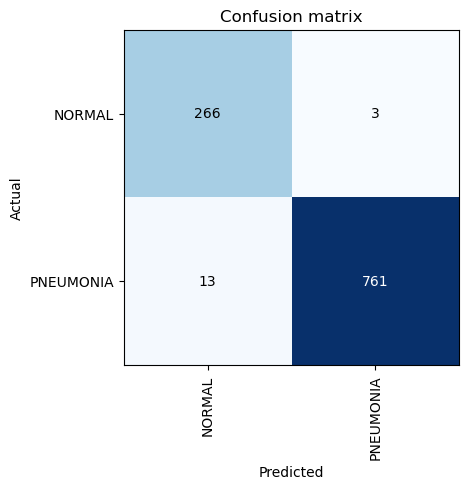

In [9]:
# Modelni baholaymiz va confusion matrix ko‘rsatamiz
interpretation = ClassificationInterpretation.from_learner(image_classifier)
# Confusion matritsasini tasvirlaymiz
interpretation.plot_confusion_matrix()

In [10]:
# Ushbu obyekt model natijalarini tahlil qilish uchun ishlatiladi.
interpretation.print_classification_report()

              precision    recall  f1-score   support

      NORMAL       0.95      0.99      0.97       269
   PNEUMONIA       1.00      0.98      0.99       774

    accuracy                           0.98      1043
   macro avg       0.97      0.99      0.98      1043
weighted avg       0.99      0.98      0.98      1043



In [11]:
# Modelni saqlaymiz
image_classifier.export('pnevmaniya.pkl')

In [13]:
# CSV faylini o'qiymiz
csv_o = pd.read_csv("C:/Users/Asus/Downloads/pnevmoniya/sample_solution.csv")

# Ma'lumotlarni ko'rsatamiz
csv_o

,id,labels
0,test_img_10001.jpeg,0
1,test_img_10002.jpeg,0
2,test_img_10003.jpeg,0
3,test_img_10004.jpeg,0
4,test_img_10005.jpeg,0
...,...,...
619,test_img_10620.jpeg,0
620,test_img_10621.jpeg,0
621,test_img_10622.jpeg,0
622,test_img_10623.jpeg,0


In [16]:
from fastai.vision.all import PILImage


# Test rasm fayllari bo'yicha iteratsiya qilish
for x in range(len(csv_o)):
    # Rasm identifikatorini olamiz
    label = csv_o.loc[x, 'id']
    
    # Rasmni o'qiymiz
    img = PILImage.create(Path(f"C:/Users/Asus/Downloads/pnevmoniya/test/{label}"))
    
    # Model yordamida tasniflymiz
    prediction, prediction_id, probs = image_classifier.predict(img)
    
    # Natijalarni 'labels' ustuniga saqlaymiz
    csv_o.loc[x, 'labels'] = np.array(probs[1])

# Natijani ko'rsatamiz
csv_o.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_1832\3751729000.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.999997615814209' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  csv_o.loc[x, 'labels'] = np.array(probs[1])


,id,labels
0,test_img_10001.jpeg,0.999998
1,test_img_10002.jpeg,0.015045
2,test_img_10003.jpeg,0.959025
3,test_img_10004.jpeg,0.999996
4,test_img_10005.jpeg,0.001183


In [23]:
# 'labels' ustunidagi qiymatlarni almashtirish kodi
# PNEUMONIA -> 1
# NORMAL    -> 0
# csv_o['labels'].replace({'PNEUMONIA': 1, 'NORMAL': 0}, inplace=True)

# O'zgartirilgan ma'lumotlarni CSV fayliga yozib saqlash
# Fayl nomi: 'model_results.csv'
# index=False - indekslar CSV faylda yozilmaydi
csv_o.to_csv('C:/Users/Asus/Downloads/pnevmoniya/model_results.csv', index=False)

In [24]:
pd.read_csv("C:/Users/Asus/Downloads/pnevmoniya/model_results.csv")

,id,labels
0,test_img_10001.jpeg,0.999998
1,test_img_10002.jpeg,0.015045
2,test_img_10003.jpeg,0.959025
3,test_img_10004.jpeg,0.999996
4,test_img_10005.jpeg,0.001183
...,...,...
619,test_img_10620.jpeg,0.999943
620,test_img_10621.jpeg,0.824135
621,test_img_10622.jpeg,0.999991
622,test_img_10623.jpeg,0.999124
